In [9]:
#%matplotlib widget
import matplotlib.pyplot as plt 

import ipywidgets as widgets
import numpy as np
import os
import pickle
import sys, math
from glob import glob

import colour
from colour_hdri.plotting import plot_tonemapping_operator_image
colour.plotting.colour_style()
colour.utilities.describe_environment();

#import cv2 as cv
import skimage
import imageio

from astropy.io import fits
from colour.models import RGB_COLOURSPACES, RGB_luminance

colorspace = RGB_COLOURSPACES['sRGB']

import astrobf
from astrobf.utils import mask_utils
from astrobf.utils.mask_utils import *

from matplotlib import patches
from matplotlib.collections import PatchCollection

import statmorph
from statmorph.utils import image_diagnostics

import re

*                                                                             *
*   Interpreter :                                                             *
*       python : 3.8.5 (default, Sep  4 2020, 07:30:14)                       *
*                [GCC 7.3.0]                                                  *
*                                                                             *
*   colour-science.org :                                                      *
*       colour : 0.3.16                                                       *
*       colour-hdri : 0.1.8                                                   *
*                                                                             *
*   Runtime :                                                                 *
*       imageio : 2.9.0                                                       *
*       matplotlib : 3.3.2                                                    *
*       networkx : 2.5                  

In [11]:
dataset = ['EFIFI','Nair'][1]
basedir = ['../../bf_data/EFIGI_catalog/','../../bf_data/Nair_and_Abraham_2010/'][1]
fitsdir = basedir + ['fits_temp_Jan_19/','fits_temp_Dec_28/', 'fits_temp_Feb_3/'][2]

out_dir = basedir+'out1/'

#fns_g = glob(fitsdir+"*/*g.fits")
#fns_g.sort()
fns_r = glob(fitsdir+"*/*r.fits")
fns_r.sort()
#fns_i = glob(fitsdir+"*/*i.fits")
#fns_i.sort()

eps = 1e-6

# Load StatMorph Results

In [846]:
all_morphs = glob(out_dir+"Morphs/final*.pickle")
all_morphs.sort()
all_morphs

['../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs00499.pickle',
 '../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs00999.pickle',
 '../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs01499.pickle',
 '../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs01999.pickle',
 '../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs02499.pickle',
 '../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs02999.pickle',
 '../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs03499.pickle',
 '../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs03999.pickle',
 '../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs04499.pickle',
 '../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs04999.pickle',
 '../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs05499.pickle',
 '../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs05999.pickle',
 '../../bf_data/Nair_and_Abraham_2010/out1/Morphs/final_morphs06430.pickle']

###  Collect good galaxy morphs

In [850]:
# Good galaxies after visual inspection
good_list = glob(out_dir+"stat_png/good/*.png")
good_gids=[]
for gg in good_list:
    good_gids.append(gg.split("/")[-1].split("_")[1])
good_gids.sort()

In [849]:
"""
# Corresponding morphs
all_morphs = glob(out_dir+"Morphs/final_morphs*.pickle")
#good_morphs=[]
for alm in all_morphs:
    mps = pickle.load(open(alm,'rb'))
    for morph in mps:
        if morph._gid in good_gids:
            good_morphs.append(morph)

#pickle.dump(good_morphs, open(out_dir+"Morphs/good{}.pickle".format(len(good_morphs), "wb"), 
#                              protocol=pickle.HIGHEST_PROTOCOL)
"""

'\n# Corresponding morphs\nall_morphs = glob(out_dir+"Morphs/final_morphs*.pickle")\n#good_morphs=[]\nfor alm in all_morphs:\n    mps = pickle.load(open(alm,\'rb\'))\n    for morph in mps:\n        if morph._gid in good_gids:\n            good_morphs.append(morph)\n\n#pickle.dump(good_morphs, open(out_dir+"Morphs/good{}.pickle".format(len(good_morphs), "wb"), \n#                              protocol=pickle.HIGHEST_PROTOCOL)\n'

### Morphology matrix

In [852]:
# Put useful measurements into a numpy array
fields = [
    'xc_centroid', 'yc_centroid', 
    'ellipticity_centroid', 'elongation_centroid', 'orientation_centroid',
    'xc_asymmetry', 'yc_asymmetry',
    'ellipticity_asymmetry', 'elongation_asymmetry', 'orientation_asymmetry',
    'rpetro_circ', 'rpetro_ellip', 'rhalf_circ', 'rhalf_ellip',
    'r20', 'r80',
    'gini', 'm20', 'gini_m20_bulge', 'gini_m20_merger',
    'sn_per_pixel', 'concentration', 'asymmetry', 'smoothness',
    'intensity', 'deviation', 'multimode',
    'sersic_xc', 'sersic_yc', 'sersic_amplitude', 'sersic_rhalf', 'sersic_n', 'sersic_ellip', 'sersic_theta',
    'sky_mean', 'sky_median', 'sky_sigma']

ngal = len(good_gids)
result_arr = np.zeros(ngal, 
                      dtype=[('id','<U24'),('ttype',int),('flag',bool),('flag_sersic',bool)]
                           +[(ff,float) for ff in fields])
i=0
for alm in all_morphs:
    mps = pickle.load(open(alm,'rb'))
    for morph in mps:
        if morph._gid in good_gids:
            result_arr[i]['id'] = morph._gid
            for ff in fields:
                result_arr[i][ff] = getattr(morph, ff)
            i+=1
        else:
            pass

In [853]:
print("Number of 'bad measurements afther visual inspection =", np.sum(result_arr['flag']))

Number of 'bad measurements afther visual inspection = 0


'multimode' and 'deviation' seem less useful unless scaled otherwise. 

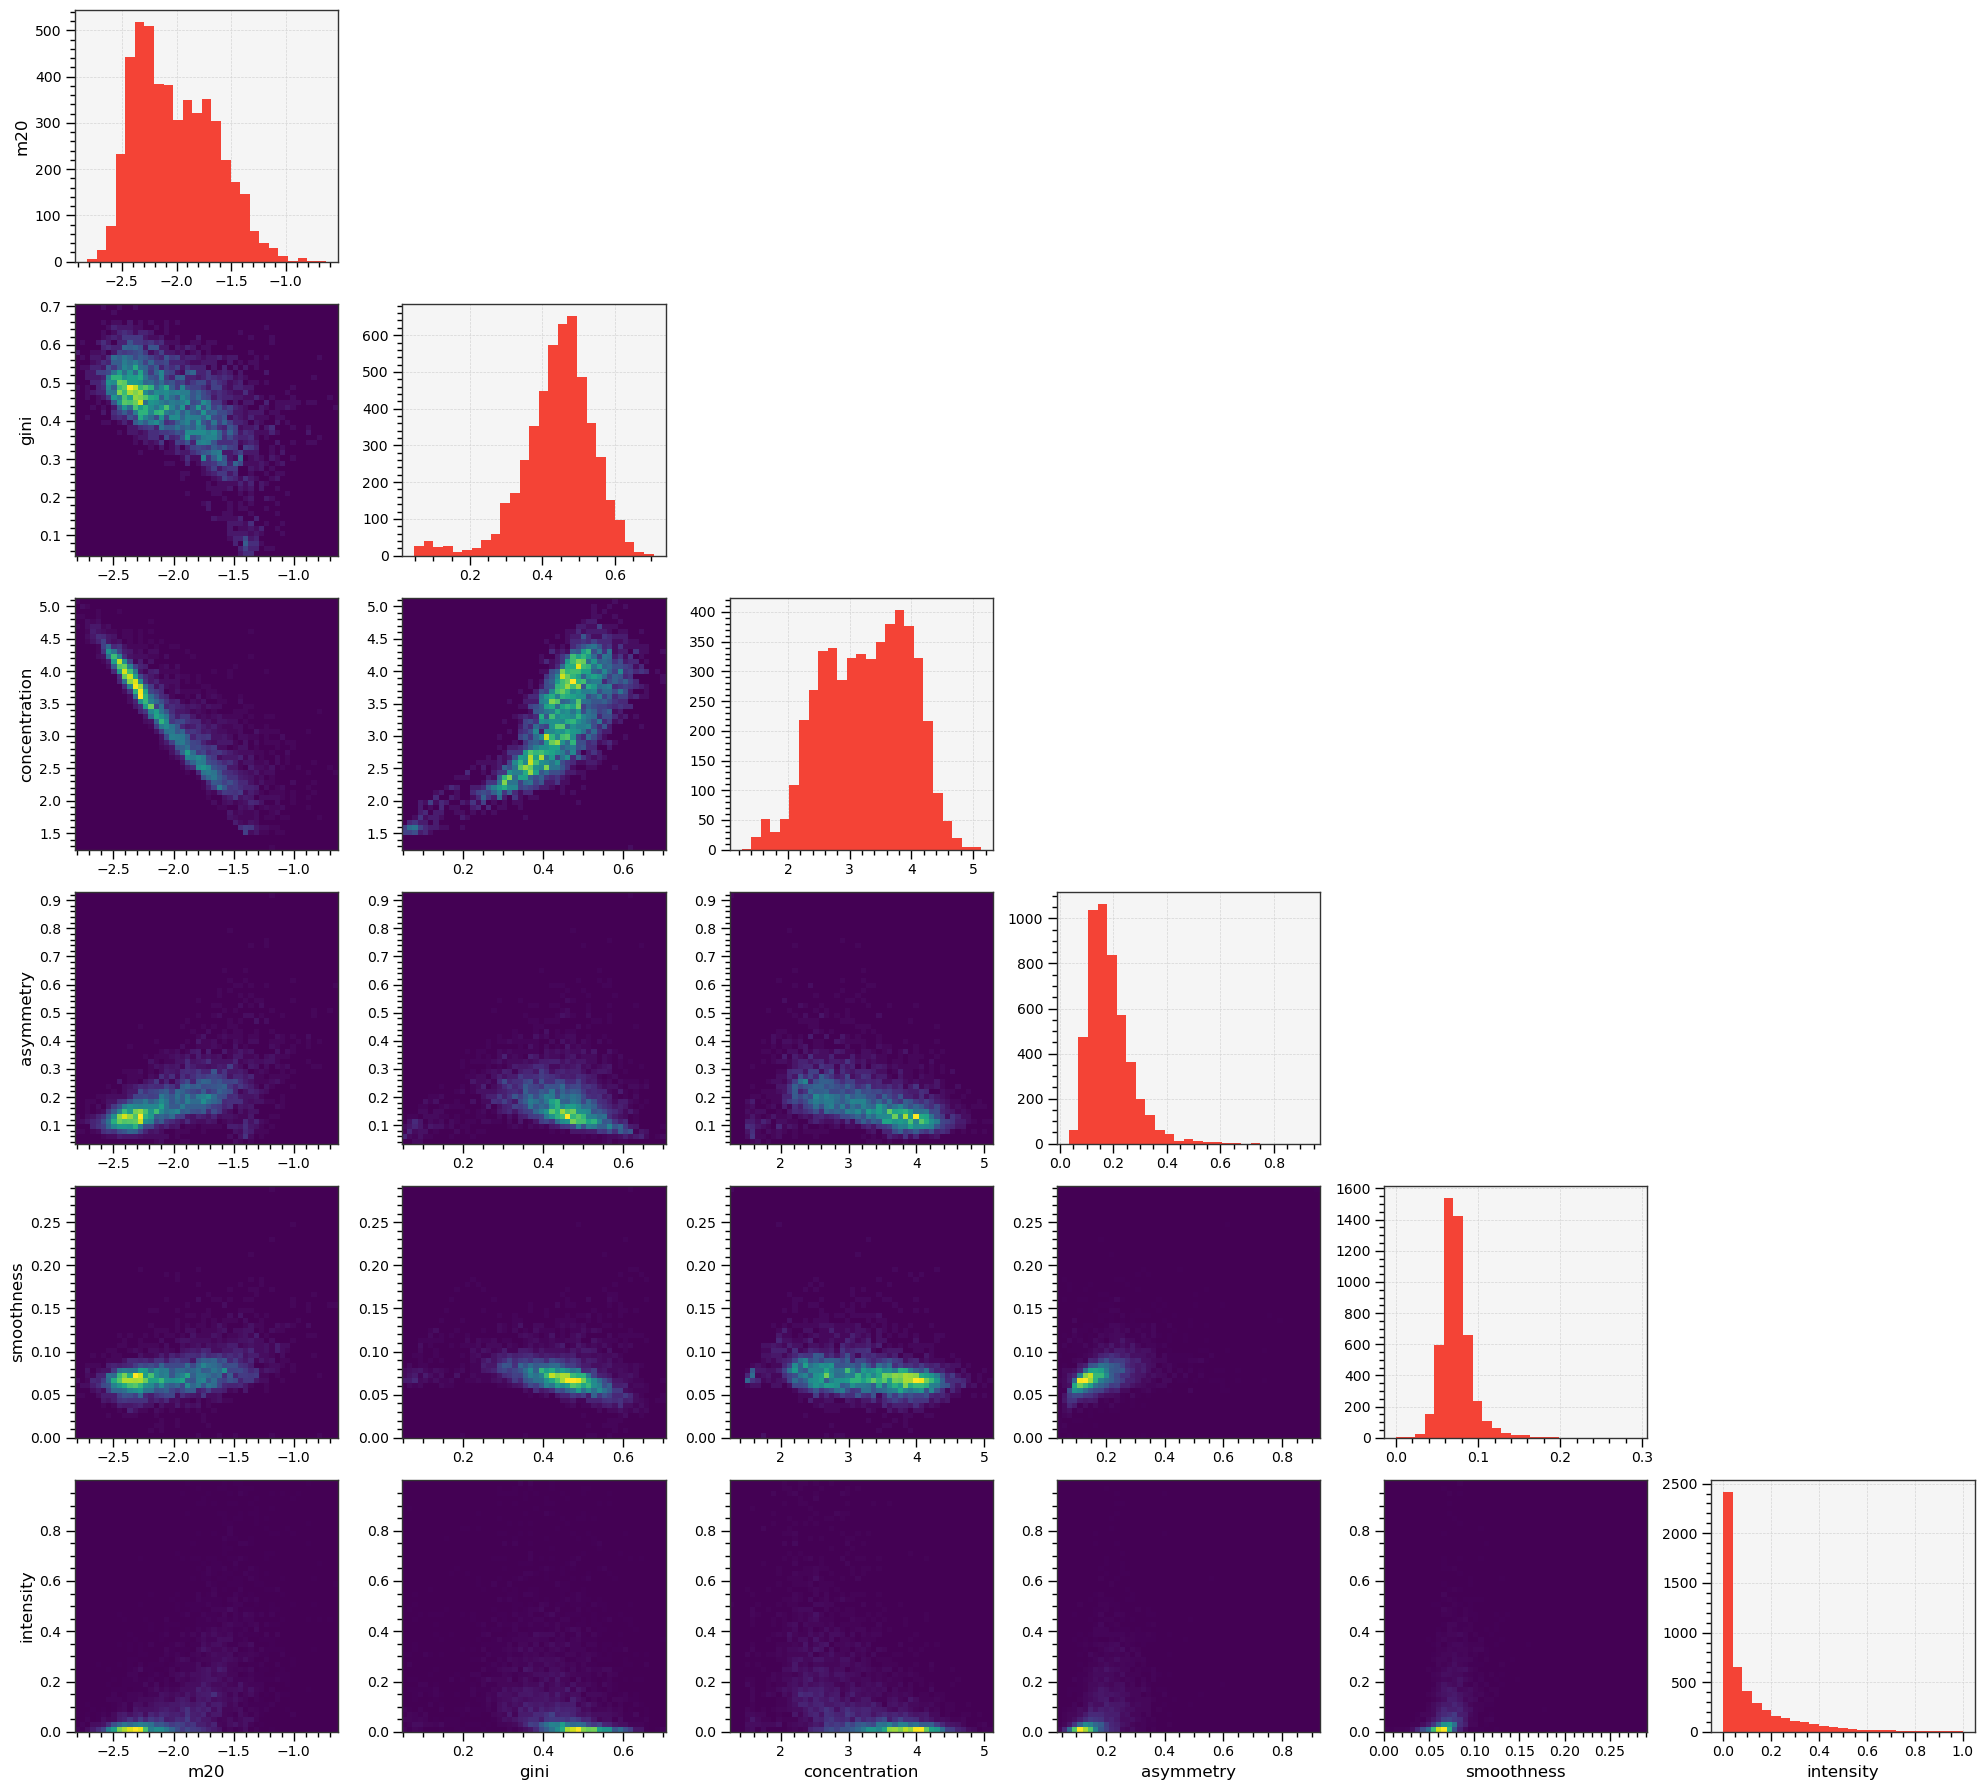

In [70]:
# Draw a Matrix plot
targets = ['m20', 'gini', 'concentration', 'asymmetry', 'smoothness', 'intensity']
n_targets = len(targets)
fig, axs = plt.subplots(n_targets,n_targets)
fig.set_size_inches(20,18)
for i, (rows, tg_r) in enumerate(zip(axs,targets)):
    for j, (ax, tg_c) in enumerate(zip(rows,targets)):
        if i < j:
            ax.axis('off') 
            continue
        if tg_r == tg_c:
            ax.hist(result_arr[tg_c], bins=25)
        else:
            ax.hist2d(result_arr[tg_c], result_arr[tg_r], bins=50)
        if j==0: 
            ax.set_ylabel(f'{tg_r}')
        if i==n_targets-1:
            ax.set_xlabel(f'{tg_c}')

plt.tight_layout()
plt.savefig(out_dir+"Morph_matrix.png", dpi=144, facecolor='white')
plt.show()

# StatMorph + Nair Catalog

In [798]:
if dataset == "Nair":
    import pandas as pd
    fn_cat = '../../bf_data/Nair_and_Abraham_2010/catalog/table2.dat'
    headings =['ID', 'RA', 'dec', 'zred', 'zred_q', 
               'mg', 'mr', 'Mag_r', 'logLg', 'Rpetro', 
               'Rp50', 'Rp90', 'spID', 'logM', 'Age', 
               'g_r', 'sfrt', 'sfrm', 'mu_g', 'mu_M',
               'MvoerL','area', 'bovera', 'Seeing', 'ng',
               'nr', 'chi2g', 'chi2r', 'R50n', 'R90n', 
               'sigma', 'e_sigma', 'VoverVmax', 'TT', 'Bar', 
               'Ring', 'f_Ring', 'Lens', 'TTq', 'Pair', 
               'f_Pair', 'Int', 'nt', 'RC3', 'Tt']
    
    colspecs = [(l[0]-1, l[1]-1) for l in [(1,21), (22,28), (32,38), (42,46), (50,54), 
                (56,61), (63,68), (70,76), (78,83), (85,90), 
                (93,99), (101,106), (108, 121), (123,128), (130,135), 
                (138,143), (147,153), (157,163), (165,170), (172,178), 
                (180,185), (189,195), (197,201), (205,208), (224, 228),
                (231,235), (237,245), (247,255), (257,262), (265,270),
                (272,278), (280,286), (288,292), (376,379), (380,382),
                (383,386), (387,389), (390,392), (393,394), (395,397),
                (398,401), (402,406), (407,409), (410,417), (418,421)] ]

    dat = pd.read_fwf(fn_cat, colspecs=colspecs, 
                     names=headings, header=None)

    with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
        print (dat)    
    
    # follow result_arr's convention
    dat['ID'] = dat['ID'].apply(lambda x: x.replace('-','m'))
    dat['ID'] = dat['ID'].apply(lambda x: x.replace('+','p'))
    dat = dat.sort_values("ID")
    cat = dat.to_records(index=False, column_dtypes={'ID':'<U24', 'spID':'<U14', 'RC3':'<U7'})

elif dataset == 'EFIGI':
    fn_cat = '../../bf_data/EFIGI_catalog/catalog/efigi.dat'

                         ID      RA    dec  zred  zred_q     mg     mr  Mag_r  \
0      J155341.74-003422.84  238.42  -0.57  0.07    1.00  15.82  15.05 -22.08   
1      J155146.83-000618.62  237.94  -0.10  0.05    1.00  15.51  14.60 -21.56   
2      J154453.22+002415.48  236.22   0.40  0.03    1.00  15.63  14.83 -20.27   
3      J154711.32+002424.81  236.79   0.40  0.03    0.96  15.71  15.15 -20.10   
4      J154514.39+004619.89  236.31   0.77  0.01    1.00  15.34  14.95 -18.38   
...                     ...     ...    ...   ...     ...    ...    ...    ...   
14029  J124719.07+154235.64  191.83  15.71  0.06    1.00  15.78  14.90 -21.85   
14030  J130510.16+152606.67  196.29  15.43  0.05    1.00  15.31  14.59 -21.62   
14031  J131525.21+152522.23  198.85  15.42  0.02    1.00  15.25  14.34 -20.14   
14032  J132045.57+151532.75  200.19  15.26  0.02    0.99  15.72  14.93 -19.32   
14033  J132135.96+151917.80  200.40  15.32  0.02    1.00  15.47  14.80 -19.47   

       logLg  Rpetro   Rp50

In [854]:
# 
inds = cat['ID'].searchsorted(result_arr['id'])
print("Is every element matched?: ", np.all(cat[inds]['ID'] == result_arr['id']))
result_arr['ttype'] = cat[inds]['TT']

Ttypes = np.unique(result_arr['ttype'])

Is every element matched?:  True


In [855]:
pickle.dump(result_arr, open(out_dir+'result_arr.pcikle', 'wb'))

In [249]:
result_arr.dtype

dtype([('id', '<U24'), ('ttype', '<i8'), ('flag', '?'), ('flag_sersic', '?'), ('xc_centroid', '<f8'), ('yc_centroid', '<f8'), ('ellipticity_centroid', '<f8'), ('elongation_centroid', '<f8'), ('orientation_centroid', '<f8'), ('xc_asymmetry', '<f8'), ('yc_asymmetry', '<f8'), ('ellipticity_asymmetry', '<f8'), ('elongation_asymmetry', '<f8'), ('orientation_asymmetry', '<f8'), ('rpetro_circ', '<f8'), ('rpetro_ellip', '<f8'), ('rhalf_circ', '<f8'), ('rhalf_ellip', '<f8'), ('r20', '<f8'), ('r80', '<f8'), ('gini', '<f8'), ('m20', '<f8'), ('gini_m20_bulge', '<f8'), ('gini_m20_merger', '<f8'), ('sn_per_pixel', '<f8'), ('concentration', '<f8'), ('asymmetry', '<f8'), ('smoothness', '<f8'), ('intensity', '<f8'), ('deviation', '<f8'), ('multimode', '<f8'), ('sersic_xc', '<f8'), ('sersic_yc', '<f8'), ('sersic_amplitude', '<f8'), ('sersic_rhalf', '<f8'), ('sersic_n', '<f8'), ('sersic_ellip', '<f8'), ('sersic_theta', '<f8'), ('sky_mean', '<f8'), ('sky_median', '<f8'), ('sky_sigma', '<f8')])

In [266]:
# ridgeplot
from sklearn.neighbors import KernelDensity
import matplotlib.gridspec as grid_spec

categories = Ttypes
data = result_arr
cat_name = 'ttype'
var_name = 'm20'


def ridge_plot(data, categories, var_name, cat_name,
               cmap = 'Spectral',
               figsize=(9,12),
               ymax=None,
               bandwidth=None,
               nband=50,
               hspace=-0.8,
               fn_fig=None):
    # https://matplotlib.org/matplotblog/posts/create-ridgeplots-in-matplotlib/

    cmap = matplotlib.cm.get_cmap(cmap)
    n_catagories = len(categories)
    colors = cmap(np.linspace(0,1,n_catagories))

    gs = grid_spec.GridSpec(n_catagories,1)
    fig = plt.figure(figsize=figsize)

    xmin = data[var_name].min()
    xmax = data[var_name].max()

    ax_objs = []
    heighs=[]
    if bandwidth is None:
        bandwidth = (xmax - xmin) / nband

    for i, species in enumerate(categories):
        x = np.array(data[var_name][data[cat_name] == species])
        x_d = np.linspace(xmin,xmax, 1000)

        kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
        kde.fit(x[:, None])

        logprob = kde.score_samples(x_d[:, None])

        # creating new axes object
        ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

        # plotting the distribution
        ax_objs[-1].plot(x_d, np.exp(logprob),color="#f0f0f0",lw=1)
        ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1,color=colors[i])

        # setting uniform x axis
        ax_objs[-1].set_xlim(xmin, xmax)
        
        # store heights
        heighs.append(max(np.exp(logprob)))
        #ax_objs[-1].set_ylim(0,ymax)

        # make background transparent
        rect = ax_objs[-1].patch
        rect.set_alpha(0)

        # remove borders, axis ticks, and labels
        ax_objs[-1].set_yticklabels([])

        if i == len(categories)-1:
            ax_objs[-1].set_xlabel(var_name, fontsize=16,fontweight="bold")
        else:
            ax_objs[-1].set_xticklabels([])

        spines = ["top","right","left","bottom"]
        for s in spines:
            ax_objs[-1].spines[s].set_visible(False)

        label = f'{species}'
        ax_objs[-1].text(xmax + 0.05*(xmax-xmin),0,label,fontweight="bold",fontsize=14,ha="right")

    if ymax is None:
        ymax = 0.7*(np.mean(heighs)+max(heighs))
    for ax in ax_objs:
        ax.set_ylim(0,ymax)
    gs.update(hspace=hspace)
    ax_objs[0].text(0.5*(xmax+xmin), ymax, var_name+' vs '+cat_name, fontweight="bold",fontsize=14)
    plt.tight_layout()
    if fn_fig is not None:
        plt.savefig(fn_fig, facecolor='white')
        plt.close()
    else:
        plt.show()

In [356]:
ridge_plot(result_arr, Ttypes, var_name='m20', cat_name='ttype',fn_fig=out_dir+"ridge_M20.png")

ridge_plot(result_arr, Ttypes, var_name='gini', cat_name='ttype',fn_fig=out_dir+"ridge_gini.png")

ridge_plot(result_arr, Ttypes, var_name='concentration', cat_name='ttype',fn_fig=out_dir+"ridge_concentration.png")

ridge_plot(result_arr, Ttypes, var_name='asymmetry', cat_name='ttype',fn_fig=out_dir+"ridge_asymmetry.png")

ridge_plot(result_arr, Ttypes, var_name='smoothness',
           cat_name='ttype',fn_fig=out_dir+"ridge_smoothness.png")



<ipython-input-353-355006a2ed5d>:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


# Correlation matrix

In [654]:
def view_fields(arr, fields):
    return arr.getfield(np.dtype({name:arr.dtype.fields[name] for name in fields}))

def select_columns(arr, fields):
    dtype = np.dtype([(name, arr.dtype.fields[name][0]) for name in fields])
    newarr = np.zeros(arr.shape, dtype=dtype)
    for name in dtype.names:
        newarr[name] = arr[name]
    return newarr

def struct_to_ndarray(strarr):
    """
    Takes 'contiguous' structured array. Doesn't work with discontinuous views!
    
    """
    return strarr.view(np.float64).reshape(strarr.shape + (-1,))

In [695]:
# Plot correlation matrix
import sklearn

def plot_correlation_matrix(arr, fields, cmap = 'coolwarm', fn_fig=None):
    from sklearn.preprocessing import StandardScaler
    stdsc = StandardScaler()
    X_std = stdsc.fit_transform(arr)
    #cov_mat =np.cov(X_std.T) ... What's the difference??
    cov_mat = np.corrcoef(X_std.T)
    plot_annotate_lower_heatmap(cov_mat, fields, fn_fig=fn_fig)

def plot_annotate_lower_heatmap(cov_mat, labels, cmap = 'coolwarm', fn_fig=None):
    fig, ax = plt.subplots(figsize=(6,5))
    # Lower triangle 
    Lower = np.tril(cov_mat)
    Lower[Lower==0] = np.nan
    im = ax.imshow(Lower, cmap=cmap, )

    # Enable ticks to show labels.
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    # But ticks come with guiding grid. Turn them off.
    ax.grid(False)

    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # tick length to 0
    ax.tick_params(axis=u'both', which=u'both',length=0)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Annotate values
    for i in range(len(labels)):
        for j in range(len(labels)):
            if i >= j:
                text = ax.text(j, i, f'{Lower[i, j]:.2f}',
                           ha="center", va="center", color="w")
    fig.colorbar(im)

    plt.tight_layout()
    if fn_fig is not None:
        plt.savefig(fn_fig, facecolor='white')
        plt.close()
    else:
        plt.show()
    

In [696]:
fields = ['gini', 'm20', 'concentration', 'asymmetry', 'smoothness']
compact = struct_to_ndarray(select_columns(result_arr, fields))
plot_correlation_matrix(compact, fields, fn_fig=out_dir+'correlation_matrix.png')

# Clustering

## Methods
- K-means
- Affinity Propagation
- Mean Shift 
- Spectral clustering
- Hierarchical clustering
- DBSCAN
- OPTICS (?)
- Birtch
++
- Self-organizing maps
- Self-organizing tree algorithm

## Evaluation metrics
(from SKlearn)
- Rand index
- Mutual Information based scores (Normalized Mutual Information / Adjusted Mutual Information)
- Homogeneity / completenss / V-measure
- Fowlkes-Mallows scores
- Silhouette Coefficient(width)
- Calinski-Harabasz Index
- Davies-Bouldin Index
- Contingency Matrix
- Pair Confusion Matrix
++
- Connectivity
- Dunn index

## K-means

### Initialization
- k-means++
- random
- based on PCA
- and other dimenstionality reduction technique



In [603]:
def dunn_index(pts, labels, centroids):
    """
    https://stackoverflow.com/a/60666838/4294919
    
    Scales poorly with large number of clusters!
    """
    # O(k n log(n)) with k clusters and n points; better performance with more even clusters
    max_intracluster_dist = max(diameter(pts[labels==i]) for i in np.unique(labels))
    # O(k^2) with k clusters; can be reduced to O(k log(k))
    # get pairwise distances between centroids
    cluster_dmat = spatial.distance_matrix(centroids, centroids)
    # fill diagonal with +inf: ignore zero distance to self in "min" computation
    np.fill_diagonal(cluster_dmat, np.inf)
    min_intercluster_dist = cluster_sizes.min()
    return min_intercluster_dist / max_intracluster_dist


In [663]:
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation, Birch, DBSCAN, MeanShift, SpectralClustering
from sklearn.pipeline import make_pipeline

In [718]:
from time import time
from sklearn import metrics
def bench_clustering(clu, name, data, labels):
    """Benchmark to evaluate the clu initialization methods.

    Parameters
    ----------
    clu : clu instance
        A :class:`~sklearn.cluster.A_clustering_method` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """

    t0 = time()
    estimator = make_pipeline(StandardScaler(), clu).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(data, estimator[-1].labels_,
                                 metric="euclidean", sample_size=300,)
    ]

    return results
    

In [685]:
clustering_methods =[
    AgglomerativeClustering,
    AffinityPropagation,
    Birch,
    DBSCAN,
    MeanShift,
    SpectralClustering
]

In [719]:
from sklearn.decomposition import PCA
def run_bench(data, labels, n_clusters):
    """
    labels needed to evaluate some metrics requiring supervision.
    """
    print(82 * '_')
    print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')
    # Show the results
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}")
    
    
    kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4,
                    random_state=0)
    results = bench_clustering(kmeans, name="k-means++", data=data, labels=labels)
    print(formatter_result.format(*results))
    
    kmeans = KMeans(init="random", n_clusters=n_clusters, n_init=4, random_state=0)
    results = bench_clustering(kmeans, name="random", data=data, labels=labels)
    print(formatter_result.format(*results))

    pca = PCA(n_components=n_clusters).fit(data)
    kmeans = KMeans(init=pca.components_, n_clusters=n_clusters, n_init=1)
    results = bench_clustering(kmeans, name="PCA-based", data=data, labels=labels)
    print(formatter_result.format(*results))

    print(82 * '_')

In [720]:
run_bench(compact[:,:5], ttype_ind, 2)

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.017s	14085	0.107	0.375	0.166	0.090	0.165	0.511
random   	0.014s	14085	0.107	0.377	0.167	0.090	0.166	0.526
PCA-based	0.004s	14085	0.107	0.376	0.167	0.091	0.166	0.501
__________________________________________________________________________________


## Pipelining SKLearn
https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf


In [666]:
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [659]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

prep = ColumnTransformer(transformers=[('num', numeric_transformer, select_columns(result_arr, fields))])

In [ ]:
# pre-processing
stdsc = StandardScaler()
X_std = stdsc.fit_transform(compact)

In [708]:
binary=True
if not binary:
    # sparse Ttype into a compact array ... or ... encoding
    ttype_code = np.digitize(result_arr['ttype'], bins=list(Ttypes)+[100], right=True)
    n_clusters=len(Ttypes)
else:
    # Binary classification 
    n_clusters=2
    ttype_code = np.zeros(len(result_arr), dtype=np.int8)
    ind_positive = np.where((result_arr['ttype'] > 3) * (result_arr['ttype'] < 6))[0]
    print("positive samples {}/{}".format(len(ind_positive), len(result_arr)))
    ttype_code[ind_positive] = 1 # Zero otherwise

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(compact[:,:4])

plot_2d_clusters(kmeans, compact, fields, ttype_code, 
                 n_clusters=2,
                 ix=0, iy=1, fn_fig=out_dir+"K-means_side-by-side.png")

positive samples 1088/4905


In [700]:
def plot_2d_clusters(clu, data, features, org_label, 
                     n_clusters=2, 
                     ix=0, 
                     iy=1, 
                     cmap = 'viridis', 
                     fn_fig = None):
    """
    Expects sklearn clu instance. 
    Needs clu.cluster_centers_, clu.labels_ and clu.n_clusters
    """
    xlabel=features[ix]
    ylabel=features[iy]

    fig, axs = plt.subplots(1,2)
    fig.suptitle(ylabel+' vs '+xlabel, fontsize=20)
    axs[0].scatter(data[:,ix], data[:,iy], c=clu.labels_, s=10, alpha=0.6, cmap=cmap)
    #for ic, centers in enumerate(clu.cluster_centers_):
    axs[0].scatter(clu.cluster_centers_[:,ix],
                clu.cluster_centers_[:,iy], s=100, c=range(1,clu.n_clusters+1), cmap=cmap)
    axs[0].set_title("K-means")
    axs[1].set_title("Original")
    axs[1].scatter(data[:,ix], data[:,iy], c=org_label, s=10, alpha=0.6, cmap=cmap)
    axs[1].scatter(clu.cluster_centers_[:,ix],
                clu.cluster_centers_[:,iy], s=100, c=range(1,clu.n_clusters+1), cmap=cmap)
    # add axis labels
    for ax in axs:
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
    
    plt.tight_layout()
    if fn_fig is not None:
        plt.savefig(fn_fig, facecolor='white')
        plt.close()
    else:
        plt.show()
    

# Bayesian Optimization

In [761]:
def tonemapping_operator_generic(x,
                             a=0.125,
                             d=0.975,
                             mid_in=0.25,
                             mid_out=0.18):
    hdr_max = x.max()
    ad = a * d
    midi_pow_a  = pow(mid_in, a)
    midi_pow_ad = pow(mid_in, ad)
    hdrm_pow_a  = pow(hdr_max, a)
    hdrm_pow_ad = pow(hdr_max, ad)
    u = hdrm_pow_ad * mid_out - midi_pow_ad * mid_out
    v = midi_pow_ad * mid_out

    b = -((-midi_pow_a + (mid_out * (hdrm_pow_ad * midi_pow_a - hdrm_pow_a * v)) / u) / v)
    c = (hdrm_pow_ad * midi_pow_a - hdrm_pow_a * v) / u

    x[x>hdr_max] = hdr_max
    z = np.power(x, a)
    return z / (np.power(z, d) * b + c)

# good galaxies: 4890


## BO : measure Gini, M20, Asym, and size

In [904]:
from statmorph.utils import image_diagnostics
#import make_figure

def get_fn(gid_string):
    return glob('../../bf_data/Nair_and_Abraham_2010/fits_temp_Feb_3/' + gid_string + '/*-r.fits')[0]

def gen_fn_img(morph, img_name):
    return out_dir+f'stat_png/tmo_{img_name}_summary.png'

In [949]:
def measure_morph(params, good_fns, results):
    """
    tmo_params = {'a':a, 'd':b, 'mid_in':c, 'mid_out':d}
    """
    fields = ['gini', 'm20', 'concentration', 'asymmetry', 'smoothness']
    tmo_params = {'a':params[0], 'd':params[1], 'mid_in':params[2], 'mid_out':params[3]}
    print("TMO params used:", tmo_params)
    for i, fn in enumerate(good_fns):
        
        img_name = fn.split("/")[-2]
        assert results[i]['ID'] == img_name
        #print(i, img_name)
        hdulist = fits.open(fn)
        # Ensure pixel values are positive
        img = hdulist[0].data
        img -= (img.min() - eps) 

        # Load auxilary data
        # combine mask, img, and weight
        mask = pickle.load(open(out_dir+f"/masks/{img_name}_mask.pickle", 'rb'))
        weight = fits.open(fn.replace(".fits", ".weight.fits"))[0].data

        subtracted = img.copy()
        subtracted[~mask] = 0
        
        tonemapped = tonemapping_operator_generic(subtracted, **tmo_params)
        morph = statmorph.source_morphology(tonemapped, mask, weightmap=weight, sersic_maxiter=0)[0]
        hdulist.close()

        for name in fields:
            results[i][name] = getattr(morph, name)
            
        #image_diagnostics.make_figure(morph, nrows=3,
        #                              savefig=gen_fn_img(morph, img_name),
        #                              img_org=None)
        
        if i % 500 == 499:
            print(i)
        #morphs.append(morph)

In [906]:
import torch
import math

# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

## BO.1 Construct model

In [940]:
from botorch.models import SingleTaskGP
from gpytorch.constraints import GreaterThan, LessThan
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.utils.sampling import draw_sobol_samples

## Initial points -- How many..?

In [ ]:
# Set up
dataset = ['EFIFI','Nair'][1]
basedir = ['../../bf_data/EFIGI_catalog/','../../bf_data/Nair_and_Abraham_2010/'][1]
fitsdir = basedir + ['fits_temp_Jan_19/','fits_temp_Dec_28/', 'fits_temp_Feb_3/'][2]

out_dir = basedir+'out1/'

fns_r = glob(fitsdir+"*/*r.fits")
fns_r.sort()

# Good galaxies WIHTOUT TM.
good_list = glob(out_dir+"stat_png/good/*.png")
good_gids=[]
for gg in good_list:
    good_gids.append(gg.split("/")[-1].split("_")[1])
good_gids.sort()

good_fns = [glob(fitsdir+gg+'/*r.fits')[0] for gg in good_gids]

print('# good galaxies:', len(good_fns))

result_arr = pickle.load(open(out_dir+'result_arr.pcikle', 'rb'))

fields = ['gini', 'm20', 'concentration', 'asymmetry', 'smoothness']
results = np.zeros(len(good_fns), 
                   dtype=[('ID', '<U24'), ('ttype',np.int8), ('flag', np.int8), 
                          ('gini', float), ('m20', float), ('asymmetry', float), 
                          ('concentration', float), ('smoothness', float)])
results['ttype'] = result_arr['ttype']
results['ID'] = result_arr['id']

In [950]:
bounds = torch.tensor([[0.0] * 4, [1., 1.5, 2., 2.]], device=device, dtype=dtype) # on-the-fly 확장을 하는 알고리즘도 있음.
compact = struct_to_ndarray(select_columns(result_arr, fields)) # initial guess around known set of parameters.


def obj(X):
    measure_morph(train_X, good_fns, results)

    # Binary classification 
    n_clusters=2
    labels = np.zeros(len(result_arr), dtype=np.int8)
    ind_positive = np.where((result_arr['ttype'] > 3) * (result_arr['ttype'] < 6))[0]
    print("positive samples {}/{}".format(len(ind_positive), len(result_arr)))
    labels[ind_positive] = 1 # Zero otherwise

    data = compact[:,:4]
    kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4,
                    random_state=0)
    eval_metrics = bench_clustering(kmeans, "k-means++", data, labels) # Last entry == 실루엣    
    return eval_metrics 

def generate_initial_data(n=5):
    # Run StatMorph
    #tmo_params_init = {'a':0.125, 'd':0.975, 'mid_in':0.25, 'mid_out':0.18}
    #tmo_params = tmo_params_inito

    
    train_X = draw_sobol_samples(bounds=bounds, n=4, q=1, seed=torch.randint(0,10000,(1,)).item()).squeeze(1)
    # Update tmo param
    train_Y = []
    
    for tx in train_X:
        train_Y.append(obj(tx))
        
        
def initialize_model()

# Or custom model??

In [923]:
from botorch.models.gpytorch import GPyTorchModel
from gpytorch.distributions import MultivariateNormal
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from botorch.utils.sampling import draw_sobol_samples


class MyModel(ExactGP, GPyTorchModel):
    
    _num_outputs = 1
    def __init__(self, train_X, train_Y):
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(
            base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)  # make sure we're on the right device/dtype
        
    #def forward(self, )
    
    
    def posterior(self, text_X):
        """
        test_X = tmo_params        
        """
    
        measure_morph(test_X, good_fns, results)
        
        # Binary classification 
        n_clusters=2
        labels = np.zeros(len(result_arr), dtype=np.int8)
        ind_positive = np.where((result_arr['ttype'] > 3) * (result_arr['ttype'] < 6))[0]
        #print("positive samples {}/{}".format(len(ind_positive), len(result_arr)))
        labels[ind_positive] = 1 # Zero otherwise

        fields = ['gini', 'm20', 'concentration', 'asymmetry', 'smoothness']
        compact = struct_to_ndarray(select_columns(result_arr, fields))
        data = compact[:,:4]
        kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4,
                        random_state=0)
        eval_metrics = bench_clustering(kmeans, "k-means++", data, labels) 
        return eval_metrics[-1] # Last entry = 실루엣

In [929]:
mm = MyModel(train_X, torch.tensor(Y0))

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)



N_TRIALS=3
N_BATCH=2
MC_SAMPLES=16

for trial in range(1, N_TRIALS + 1):
    print(f"\nTrial {trial:>2} of {N_TRIALS} ", end="")
    best_observed_ei, best_random = [], []
    
    
    best_observed_ei.append(best_observed_value_ei)
    best_random.append(best_observed_value_ei)

    
    # run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_BATCH + 1):    
        
        t0 = time.time()
        
        # fit the models
        fit_gpytorch_model(mll_ei)
        fit_gpytorch_model(mll_nei)
        
        # define the qEI and qNEI acquisition modules using a QMC sampler
        qmc_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
        
        # for best_f, we use the best observed noisy values as an approximation
        qEI = qExpectedImprovement(
            model=model_ei, 
            best_f=(train_obj_ei * (train_con_ei <= 0).to(train_obj_ei)).max(),
            sampler=qmc_sampler, 
            objective=constrained_obj,
        )
        

        # optimize and get new observation
        new_x_ei, new_obj_ei, new_con_ei = optimize_acqf_and_get_observation(qEI)
                
        # update training points
        train_x_ei = torch.cat([train_x_ei, new_x_ei])
        train_obj_ei = torch.cat([train_obj_ei, new_obj_ei])
        train_con_ei = torch.cat([train_con_ei, new_con_ei])

        # update progress
        best_random = update_random_observations(best_random)
        best_value_ei = weighted_obj(train_x_ei).max().item()
        best_observed_ei.append(best_value_ei)

        # reinitialize the models so they are ready for fitting on next iteration
        # use the current state dict to speed up fitting
        mll_ei, model_ei = initialize_model(
            train_x_ei, 
            train_obj_ei, 
            train_con_ei, 
            model_ei.state_dict(),
        )
        
        t1 = time.time()
        
        if verbose:
            print(
                f"\nBatch {iteration:>2}: best_value (random, qEI) = "
                f"({max(best_random):>4.2f}, {best_value_ei:>4.2f}, "
                f"time = {t1-t0:>4.2f}.", end=""
            )
        else:
            print(".", end="")

In [ ]:
torch.as_dd

In [ ]:
model = SingleTaskGP(train_X=train_X, train_Y=train_Y)
model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))

## BO.2 Acqusition function

In [ ]:
from botorch.acquisition import UpperConfidenceBound

UCB = UpperConfidenceBound(gp, beta=0.1)

## BO.3 Optimize

# StatMorph + EFIGI Catalog

In [110]:
catalog_fields=[('ID',int),('RA',float),('dec',float),('T',float),('T_lo',float),('T_up',float),
                ('Arm_S',float),('Arm_S_up',float),('Arm_S_lo',float),
                ('Arm_C',float),('Arm_C_up',float),('Arm_C_lo',float),
                ('Arm_R',float),('Arm_R_up',float),('Arm_R_lo',float),
                ('Bar_L',float),('Bar_L_up',float),('Bar_L_lo',float),
                ('Ring_Inner',float),('Ring_Inner_up',float),('Ring_Inner_lo',float),
                ('Ring_Outer',float),('Ring_Outer_up',float),('Ring_Outer_lo',float),
                ('Ring_Pseudo',float),('Ring_Pseudo_up',float),('Ring_Pseudo_lo',float),
                ('Perturb',float),('Perturb_up',float),('Perturb_lo',float),
                ('Dust_vis',float),('Dust_vis_up',float),('Dust_vis_lo',float),
                ('Dust_disp',float),('Dust_disp_up',float),('Dust_disp_lo',float),
                ('Floc',float),('Floc_up',float),('Floc_lo',float),
                ('Hot_spot',float),('Hot_spot_up',float),('Hot_spot_lo',float),
                ('Incl',float),('Incl_up',float),('Incl_lo',float),
                ('Contam',float),('Contam_up',float),('Contam_lo',float),
                ('Multp',float),('Multp_up',float),('Multp_lo',float)]
#fn_cat = '../../bf_data/EFIGI_catalog/catalog/efigi.dat'
full_catalog = np.genfromtxt(fn_cat, dtype=catalog_fields)

In [178]:
# PCG_name are string. Let's keep IDs only.
IDs = np.genfromtxt(fn_cat, dtype='str', usecols=0)
convert = lambda s: int(re.split('(\d+)',s)[1])
full_catalog['ID'] = np.array(list(map(convert, IDs)))

fields_stripped = [('ID',int), ('T',float), ('Arm_S',float), ('Arm_C',float), ('Arm_R',float),
                ('Bar_L',float), ('Ring_Inner',float), ('Ring_Outer',float), ('Ring_Pseudo',float),
                ('Perturb',float), ('Dust_vis',float), ('Dust_disp',float), ('Floc',float),
                ('Hot_spot',float), ('Incl',float), ('Contam',float), ('Multp',float)]
catalog = np.zeros(len(full_catalog), 
                dtype=fields_stripped)

for name,dty in fields_stripped: catalog[name] = full_catalog[name]

In [179]:
# Load catalog
ind_good = catalog['ID'].searchsorted(result_arr['id'])
goodcat = catalog[ind_good]

### Gini - M20 w/ demarcation

<IPython.core.display.Javascript object>


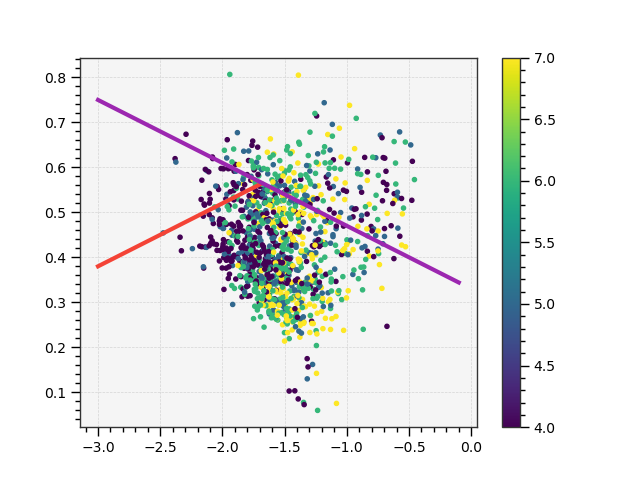

In [182]:
demarc1 = lambda x : 0.14*x + 0.8
demarc2 = lambda x : -0.14*x + 0.33

ind0 = np.where((goodcat['T'] >= -3) * (goodcat['T'] < 0))[0]
ind1 = np.where((goodcat['T'] >=  4) * (goodcat['T'] < 8))[0]
fig, ax = plt.subplots()

xx = np.array([-3, -1.7])
ax.plot(xx, demarc1(xx), lw=3)
xx = np.array([-3, -0.1])
ax.plot(xx, demarc2(xx), lw=3)
im=ax.scatter(result_arr['m20'][ind1],
              result_arr['gini'][ind1],
              c=goodcat['T'][ind1])
plt.colorbar(im)
plt.show()

### M20 vs concentration - inverse correlation expected

<IPython.core.display.Javascript object>


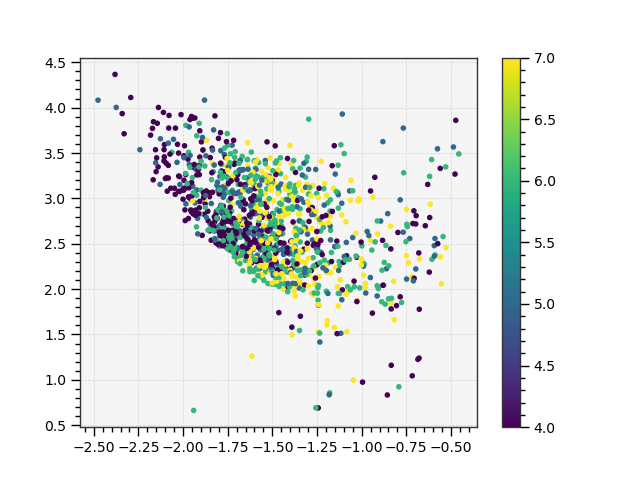

In [183]:
ind0 = np.where((goodcat['T'] >= -3) * (goodcat['T'] < 0))[0]
ind1 = np.where((goodcat['T'] >=  4) * (goodcat['T'] < 8))[0]
fig, ax = plt.subplots()

im=ax.scatter(result_arr['m20'][ind1],
              result_arr['concentration'][ind1],
              c=goodcat['T'][ind1])
plt.colorbar(im)
plt.show()

<IPython.core.display.Javascript object>


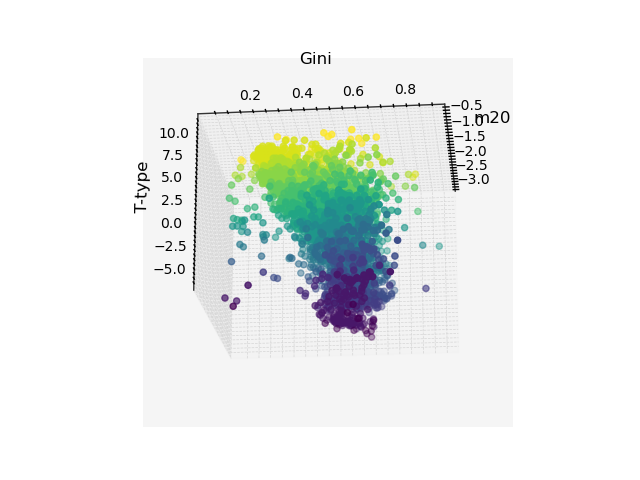

In [184]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result_arr['m20'],
           result_arr['gini'],
           goodcat['T'], c = goodcat['T'])

ax.set_xlabel('m20')
ax.set_ylabel('Gini')
ax.set_zlabel('T-type')

plt.show()

Hmmm, Can I really separate them??? 


### PCA

<IPython.core.display.Javascript object>


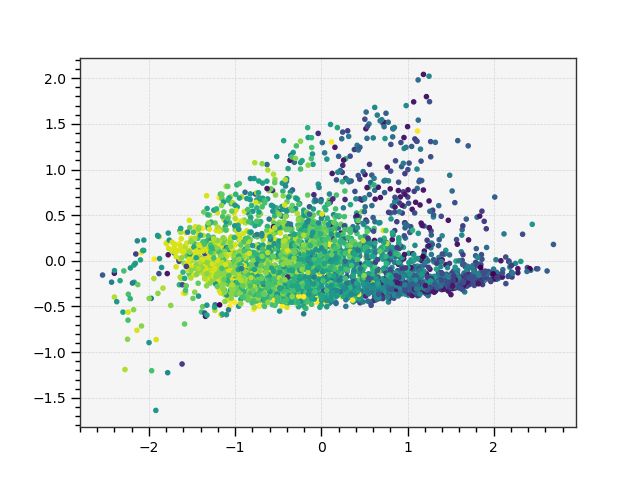

In [214]:
from sklearn import neighbors
from sklearn.decomposition import PCA

data = np.zeros((len(result_arr), 6))
for i, ff in enumerate(['m20', 'gini', 'concentration', 'asymmetry', 'smoothness', 'intensity']):
    data[:,i] = result_arr[ff]

pca = PCA(n_components = 4)

proj = pca.fit_transform(data)

plt.ion()
plt.scatter(proj[:, 0], proj[:, 1], c=goodcat['T'])
plt.show()

## simple linear regression with 6 quantities

In [264]:
from sklearn.linear_model import LinearRegression

In [282]:
data = np.zeros((len(result_arr), 6))
for i, ff in enumerate(['m20', 'gini', 'concentration', 'asymmetry', 'smoothness', 'intensity']):
    data[:,i] = result_arr[ff]
target = goodcat['T']

train = data[:3000,:]
test = data[3000:,:]
reg = LinearRegression().fit(train, target[:3000])

pred = reg.predict(test)

print(reg.coef_)

[ -0.1385608   -6.67930423  -2.36067145  -2.70995263  15.83301989
   3.08923966]


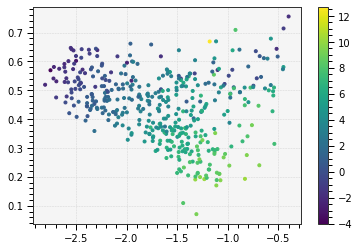

In [279]:
# Predicted Gini Vs M20
fig, ax = plt.subplots()

im=ax.scatter(test[:,0],
              test[:,1],
              c=pred)
plt.colorbar(im)
plt.show()

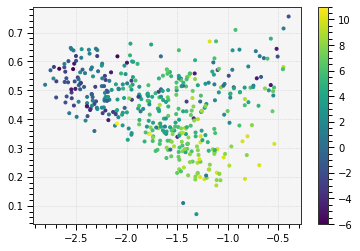

In [281]:
# Real values
fig, ax = plt.subplots()

im=ax.scatter(test[:,0],
              test[:,1],
              c=goodcat['T'][3000:])
plt.colorbar(im)
plt.show()

### SOM

In [215]:
from minisom import MiniSom

In [217]:
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

In [223]:
### Initialization and training ###
som = MiniSom(10,10,data.shape[1],sigma=1.0,learning_rate=0.5)
som.pca_weights_init(data)
print("Training...")
som.train_random(data,1000, verbose=True) # training with 100 iterations
print("\n...ready!")

Training...
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.740133686988

...ready!


In [235]:
len(np.unique(goodcat['T']))

18

In [255]:
from matplotlib import cm

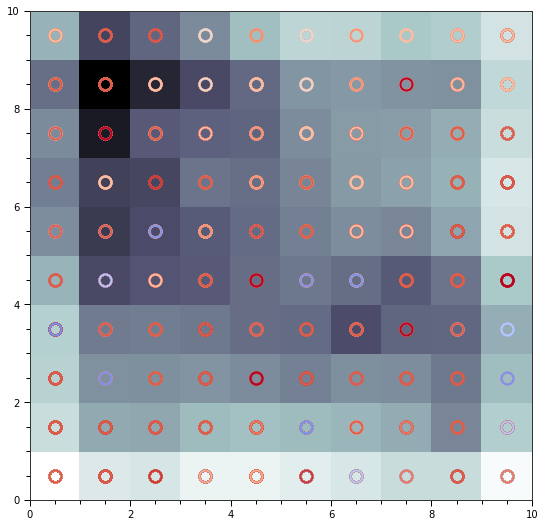

In [263]:
%matplotlib inline

plt.figure(figsize=(9, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background

target = goodcat['T'].astype(int)
colors = cm.coolwarm((target - target.min())/target.ptp())
target *= int(target.ptp())

for cnt, xx in enumerate(data):
    w = som.winner(xx)
    plt.plot(w[0]+.5, w[1]+.5, "o", markerfacecolor='None',
             markeredgecolor=colors[target[cnt]], markersize=12, markeredgewidth=2)

plt.show()

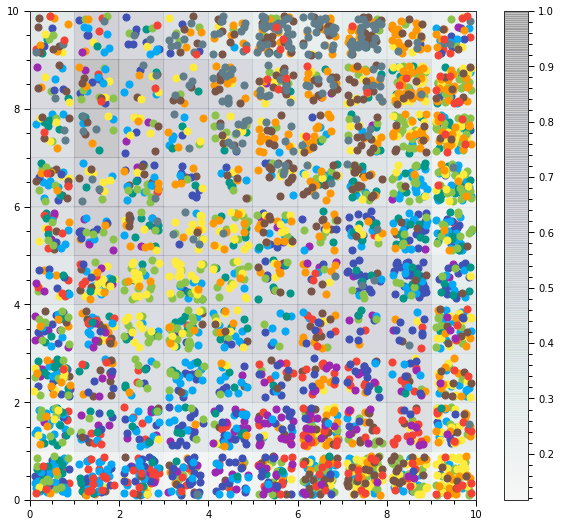

In [240]:
w_x, w_y = zip(*[som.winner(d) for d in data])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(10, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

for c in np.unique(target):
    idx_target = target==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=colors[c-1])#, label=label_names[c])
#plt.legend(loc='upper right')
plt.grid()
#plt.savefig('resulting_images/som_seed.png')
plt.show()

## TabNet
https://github.com/dreamquark-ai/tabnet
https://arxiv.org/pdf/1908.07442.pdf


1. remove ID. This is non-physical value. 
2. remove RA and dec for the same reason. 
3. T-type is a type of categorical embedding. Is it satisfactory? 
4. ignore confidential intervals for now.

In [10]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

from pytorch_tabnet.pretraining import TabNetPretrainer

clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax' # This will be overwritten if using pretrain model
                      )

X_train = smorph_arr

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=loaded_pretrain
    
) 

## cf) XGBoost

## WND-CHARM

In [12]:
from skimage.data import chelsea
img = chelsea()

matrix = PyImageMatrix()
matrix.allocate(img.shape[1], img.shape[0])
numpy_matrix = matrix.as_ndarray()
numpy_matrix[:] = img[:,:,1]

In [13]:
fv = FeatureVector( name='FromNumpyMatrix', long=True, original_px_plane=matrix )
fv.GenerateFeatures(quiet=False, write_to_disk=True)

LOADED  <FeatureVector "FromNumpyMatrix" n_features=2919 fs_col=0>


<FeatureVector "FromNumpyMatrix" n_features=2919 fs_col=0>

Best TMO params for each type(T,size) of galaxy

In [ ]:
T-type -> 살짝 mapping?? 

gsize_p = 
gsize_area =
gsize_Ra = 

e.i., 
params_t1_size_1 = (a', b', mi', mo')
params_t1_size_2 = (a', b', mi', mo')-1
params_t2_size_1 = (a', b', mi', mo')-2 
,...
,...
,...
...
.
.
.

Pixel(?)/ Size -binned
-> size dependency

WND-CHARM 



How to choose good TMO parameter set? 
->  objective : Maximize distance between T-types.

(a,b,mid_i, mid_o) = F(T-type, galaxysize)   <- Bayesian optimization? 

**사람 눈에 잘 구분되는게 목표!**
Feature set도 사람 눈에 잘 보이는 feature들이 더 중요할 것. 

In [14]:
fv.values

array([  4.46700000e+03,   1.44827590e-02,   5.44697210e-03, ...,
        -1.95719420e+00,   1.95081660e+01,   7.23149870e-01])

In [115]:
# Load data for testing
import pickle

hdulist = fits.open(fns_r[174])
img = hdulist[0].data

mask = pickle.load(open("./PGC0000243_mask.pickle", 'rb'))

img[~mask] = 0
stamp = gen_stamp(img, pad=10, aspect_ratio="no", eps=eps)
#stamp += eps
stamp -= 1.01*stamp.min()

# 3. Tone map (widget)

In [936]:
from colour.plotting import (CONSTANTS_COLOUR_STYLE, artist, override_style)
from ipywidgets import GridspecLayout, Layout, Image, Button, IntSlider, FloatSlider, ToggleButtons, VBox, HBox, Box

def tonemapping_operator_generic(x,
                             a=0.125,
                             d=0.975,
                             mid_in=0.25,
                             mid_out=0.18):
    hdr_max = x.max()
    ad = a * d
    midi_pow_a  = pow(mid_in, a)
    midi_pow_ad = pow(mid_in, ad)
    hdrm_pow_a  = pow(hdr_max, a)
    hdrm_pow_ad = pow(hdr_max, ad)
    u = hdrm_pow_ad * mid_out - midi_pow_ad * mid_out
    v = midi_pow_ad * mid_out

    b = -((-midi_pow_a + (mid_out * (hdrm_pow_ad * midi_pow_a - hdrm_pow_a * v)) / u) / v)
    c = (hdrm_pow_ad * midi_pow_a - hdrm_pow_a * v) / u

    x[x>hdr_max] = hdr_max
    z = np.power(x, a)
    return z / (np.power(z, d) * b + c)


def plot_tmo_plt(x,
                 a=0.125,
                 d=0.975,
                 mid_in=0.25,
                 mid_out=0.18,
                 log_scale=False,
                 cctf_encoding=CONSTANTS_COLOUR_STYLE.colour.colourspace.cctf_encoding):
    
    args = (a,d,mid_in, mid_out)
    image = tonemapping_operator_generic(x, *args)
    luminance_function = np.squeeze(tonemapping_operator_generic(np.linspace(0, 1, 200)))

    shape = image.shape
    bounding_box = [0, 1, 0, 1]

    image = np.clip(cctf_encoding(image), 0, 1)

    plt.ioff()
    fig = plt.figure()
    fig.set_size_inches(4,4)
    #self.fig = fig
    axes = fig.add_subplot()

    im = axes.imshow(image,
                     aspect=shape[0] / shape[1],
                     extent=bounding_box,
                     interpolation='nearest')

    lf, = axes.plot(np.linspace(0, 1, len(luminance_function)),
                       luminance_function,
                       color='red')

    if log_scale:
        axes.set_xlabel('$log_2$ Input Luminance')
        axes.set_xscale('log', basex=2)
        axes.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(0.5))
        axes.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.ion()
    plt.show()

In [937]:
hdulist = fits.open(too_deem_fns[-1])
hdulist[0].data -= (hdulist[0].data.min() - eps) 
img = hdulist[0].data

NameError: name 'too_deem_fns' is not defined

TraitError: The 'children' trait of a HBox instance contains an Instance of a TypedTuple which expected a Widget, not the FigureCanvasAgg at '0x7f3ad77f65b0'.

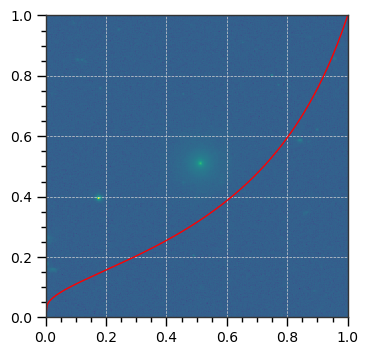

In [938]:
# Initial values 
a=0.125
d=0.975
mid_in=0.25
mid_out=0.18
log_scale=False
cctf_encoding=CONSTANTS_COLOUR_STYLE.colour.colourspace.cctf_encoding

#x = stamp
x = img
lum_points = np.linspace(0, 1, 200)

args = (a,d,mid_in, mid_out)
image = tonemapping_operator_generic(x, *args)
luminance_function = np.squeeze(tonemapping_operator_generic(lum_points))

shape = image.shape
bounding_box = [0, 1, 0, 1]

image = np.clip(cctf_encoding(image), 0, 1)


#############################
plt.ioff()
fig = plt.figure()
fig.set_size_inches(4,4)
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
axes = fig.add_subplot()

im = axes.imshow(image,
                 aspect=shape[0] / shape[1],
                 extent=bounding_box,
                 interpolation='nearest')

lf, = axes.plot(np.linspace(0, 1, len(luminance_function)),
                   luminance_function,
                   color='red')

if log_scale:
    axes.set_xlabel('$log_2$ Input Luminance')
    axes.set_xscale('log', basex=2)
    axes.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(0.5))
    axes.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ion()
#plt.show()


def update(change):
    if (change['new'] != change['old']):
        image = tonemapping_operator_generic(x,
                                             a=a.value,
                                             d=d.value,
                                             mid_in=mid_in.value,
                                             mid_out=mid_out.value)
        lum_fun = np.squeeze(tonemapping_operator_generic(lum_points,
                                                          a=a.value,
                                                          d=d.value,
                                                          mid_in=mid_in.value,
                                                          mid_out=mid_out.value))
        # Update tonemapped image
        im.set_data(image)
        lf.set_ydata(lum_fun)
        fig.canvas.draw_idle()

a=FloatSlider(min=0.1, max=1.5, step=0.01, continuous_update=False, description='a')
d=FloatSlider(min=0.5, max=3.0, step=0.01, continuous_update=False, description='d')
mid_in=FloatSlider(min=0.1, max=1, step=0.01, continuous_update=False, description='mid_in')
mid_out=FloatSlider(min=0.1, max=1, step=0.01, continuous_update=False, description='mid_out')

a.observe(update, names=['value']) # name of FloatSlider's trait to be observed
d.observe(update, names=['value'])
mid_in.observe(update, names=['value'])
mid_out.observe(update, names=['value'])

ui = VBox([a,d,mid_in,mid_out])

#mapped_image = Box(fig.canvas)
the_box = HBox([fig.canvas, ui])
the_box

In [156]:
plt.savefig("PGC0013406_1.49_1.66_0.95_0.29.png")

## TM curves applied to raw images

In [935]:
def get_values(control):
    return {ctr.description:ctr.value for ctr in control}

tmo_params = get_values(ui.children)

NameError: name 'ui' is not defined

In [934]:
tmo_params

{'a': 0.125, 'd': 0.975, 'mid_in': 0.25, 'mid_out': 0.18}

In [4]:
too_deem = [2365, 8225, 9406, 10117, 13406]

In [102]:
gids = np.asarray(gids)
too_deem_fns=[fns_r[np.where(gids==target_gid)[0].squeeze()] for target_gid in too_deem]

In [161]:
import os

try:
    out_dir = basedir+"{}_{}_{}_{}/".format(*tmo_params.values())
    os.mkdir(out_dir)
except:
    pass

In [150]:
sub_rows = 3
fig, axs = plt.subplots(sub_rows, sub_rows)
fig.set_size_inches(12,12)
axs = axs.ravel()
for ax, fn in zip(axs, too_deem_fns):
    img_name = fn.split("/")[-2]
    hdulist = fits.open(fn)

    # Ensure pixel values are positive
    hdulist[0].data -= (hdulist[0].data.min() - eps) 
    hdulist[0].data = tonemapping_operator_generic(hdulist[0].data, **tmo_params)
    #hdulist[0].data[hdulist[0].data < 10*eps] = eps
    mask, img, mask_new = mask_utils.gmm_mask(hdulist,
                                   max_n_comp=20, 
                                   sig_factor=2.0, 
                                   verbose=False, 
                                   do_plot=False,
                                   npix_min=50)
    ax.imshow(np.log10(img))
    ax.imshow(mask, alpha=0.5)
    #mask_new = mask_hull(mask, ax)
    ax.text(0.05,0.05, img_name, transform=ax.transAxes)
    pickle.dump(mask_new, open(out_dir+f"{img_name}_mask.pickle", "wb"))
plt.tight_layout()
plt.savefig(out_dir+f"deem.png", dpi=144)
plt.close()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-150-e32abd56a28e>:19: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(img))
<ipython-input-150-e32abd56a28e>:19: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(img))
<ipython-input-150-e32abd56a28e>:19: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(img))
<ipython-input-150-e32abd56a28e>:19: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(img))
<ipython-input-150-e32abd56a28e>:19: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(img))


In [933]:
import ipywidgets as widgets
from ipywidgets import FloatSlider
from IPython.display import display

from astrobf.utils import tmo_utils 

def tonemapping_operator_generic_interactive(image,
                                             a=0.125,
                                             d=0.975,
                                             mid_in=0.25,
                                             mid_out=0.18):
    args = (a,d,mid_in, mid_out)
    return tmo_utils.plot_tonemapping_operator_image(
        tmo_utils.tonemapping_operator_generic(image, *args),
        np.squeeze(tmo_utils.tonemapping_operator_generic(np.linspace(0, 1, 512), *args)),
        title='Generic Tonemapping Operator')
    

tmo_widget = widgets.interactive(
            tonemapping_operator_generic_interactive,
            image=widgets.fixed(stamp),
            a=FloatSlider(min=0.1, max=1.5, step=0.01, continuous_update=False),
            d=FloatSlider(min=0.5, max=3.0, step=0.01, continuous_update=False),
            mid_in=FloatSlider(min=0.1, max=1, step=0.01, continuous_update=False),
            mid_out=FloatSlider(min=0.1, max=1, step=0.01, continuous_update=False))

NameError: name 'stamp' is not defined

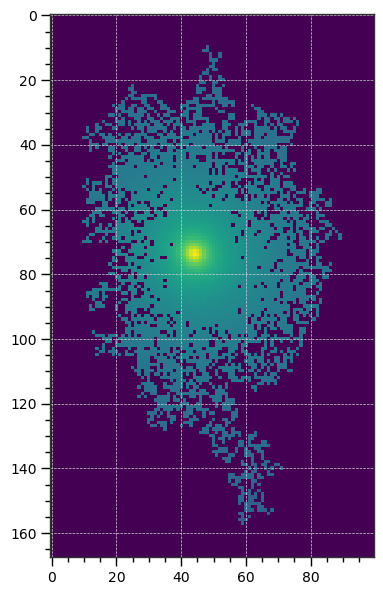

In [9]:
# Get the data out.
mapped = tmo_widget.result

plt.imshow(mapped)
plt.show()

In [ ]:
# get current tmo parameters

# 4. Feature extraction (WND-CHARM)

*Keypoint* extractors don't seem to be useful for morphological studies of galaxies.  

WND-CHARM is a generic image feature extractor. This is generic, since it calculates +2000 features of an image! 
Exact numbers of features for short/long ver. * gray/color images are given by 'diagnostics' function.

In [162]:
import wcharm
from wcharm import diagnostics

from skimage.io import imshow, imsave
from skimage.color import rgb2gray

print(diagnostics)

WND-CHARM Python API Diagnostics
Executable:
	/home/hoseung/anaconda3/envs/tm38/bin/python
PYTHONPATH environment variable:
	<unset>
WND-CHARM library path:
	/home/hoseung/Work/wnd-charm/build/lib.linux-x86_64-3.8/wcharm/wndcharm.py
WND-CHARM features major version: 4
	short: 4.1 (N = 1059)
	long: 4.2 (N = 2919)
	short_color: 4.3 (N = 2199)
	long_color: 4.4 (N = 4059)
Package versions:
	python    	3.8.0 (default, Nov  6 2019, 21:49:08)  [GCC 7.3.0]
	wndcharm  	None
	numpy     	1.19.2
	scipy     	1.5.2
	matplotlib	3.3.2
	sklearn   	0.23.2
	skimage   	0.17.2
	IPython   	7.19.0
	tifffile  	2020.12.8
	PIL       	8.1.0
	pandas    	1.1.4



WNDCHARM handles an image as a ImageMatrix. Following steps are to make an ImageMatrix object within Python. 

In [163]:
from wcharm.PyImageMatrix import PyImageMatrix

matrix = PyImageMatrix()
matrix.allocate(stamp.shape[1], stamp.shape[0])
numpy_matrix = matrix.as_ndarray()
numpy_matrix[:] = stamp

### Calculate feature vector

In [164]:
from wcharm.FeatureVector import FeatureVector

# Initialize a feature vector
fv = FeatureVector( name='FromNumpyMatrix', long=True, original_px_plane=matrix )
# fv == None for now.

fv.GenerateFeatures(quiet=False, write_to_disk=True)
print(fv.values)

CALCULATING FEATURES FROM None <FeatureVector "FromNumpyMatrix" fs_col=0>
CALCULATED: <FeatureVector "FromNumpyMatrix" n_features=2919 fs_col=0>
Writing signature file "FromNumpyMatrix-l.sig"
[  4.46700000e+03   1.44827586e-02   5.44697212e-03 ...,  -1.95719420e+00
   1.95081656e+01   7.23149867e-01]


But, why is the calculation SOOOOO fast???

Note that SIFT and SURF are **patented**, and they are missing from OpenCV install by default.  
You need additional component to be installed into opencv_contrib package. 

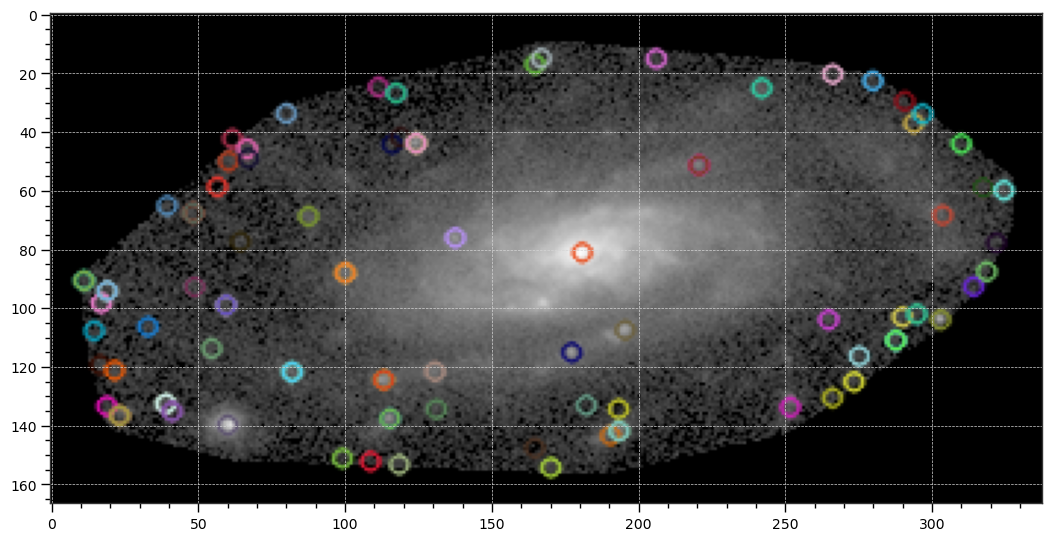

In [117]:
sift = cv.xfeatures2d.SIFT_create()
gray = (mapped*255).astype(np.uint8)
kp = sift.detect(gray,None)

shifted_img=cv.drawKeypoints(gray,kp,gray)

plt.imshow(shifted_img)
#cv.imwrite('sift_keypoints.jpg',shifted)

## What do they mean? How do I know I got reasonable feature set?

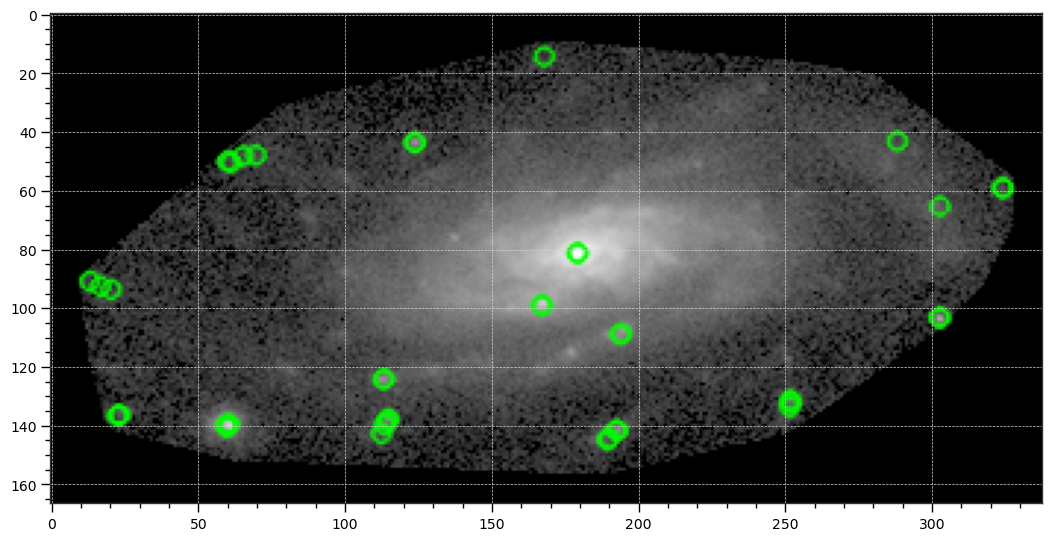

(<matplotlib.image.AxesImage at 0x7f51a7329b10>, None)

In [121]:
alg = cv.KAZE_create()
kp = alg.detect(gray)
kp, des = alg.compute(gray, kp)
img2 = cv.drawKeypoints(gray, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()

# low-level feature 1. Color
## color correlogram

# low-level feature 2. texture
## Texture classification - Local Binary Pattern

## To do: ignore outside the galaxy mask 

In [126]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb

METHOD = 'uniform'

# settings for LBP
radius = 3
n_points = 8 * radius


def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')


def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')

def do_lbp(image):
    lbp = local_binary_pattern(image, n_points, radius, METHOD)

    # plot histograms of LBP of textures
    fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
    plt.gray()

    titles = ('edge', 'flat', 'corner')
    w = width = radius - 1
    edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
    flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
    i_14 = n_points // 4            # 1/4th of the histogram
    i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
    corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                     list(range(i_34 - w, i_34 + w + 1)))

    label_sets = (edge_labels, flat_labels, corner_labels)

    for ax, labels in zip(ax_img, label_sets):
        ax.imshow(overlay_labels(image, lbp, labels))

    for ax, labels, name in zip(ax_hist, label_sets, titles):
        counts, _, bars = hist(ax, lbp)
        highlight_bars(bars, labels)
        ax.set_ylim(top=np.max(counts[:-1]))
        ax.set_xlim(right=n_points + 2)
        ax.set_title(name)

    ax_hist[0].set_ylabel('Percentage')
    for ax in ax_img:
        ax.axis('off')


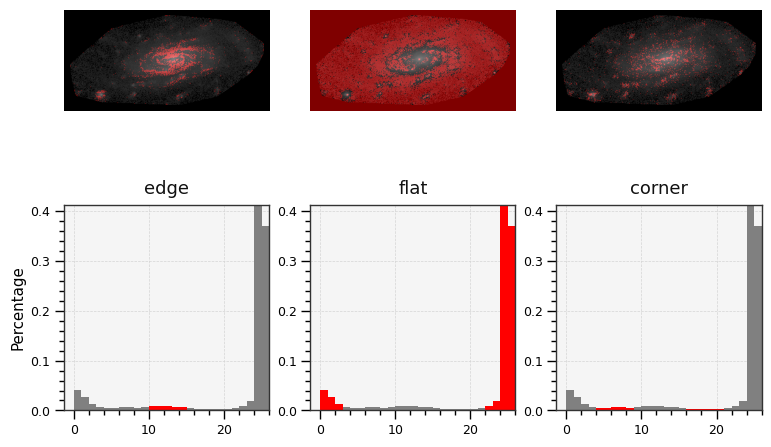

In [139]:
do_lbp(gray)

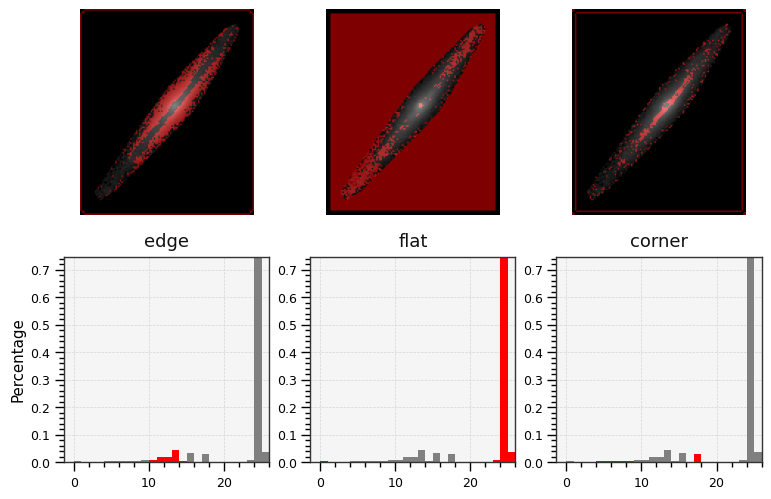

In [138]:
do_lbp(mapped)

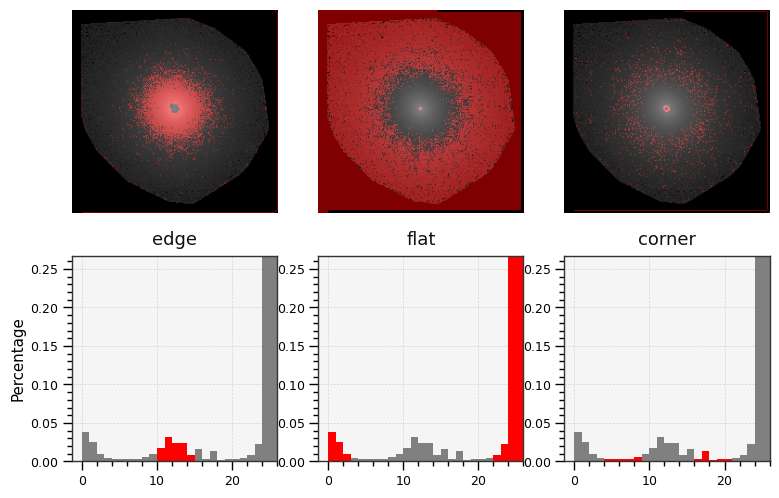

In [152]:
etg = tmo_widget.result
do_lbp(etg)

## Distance (divergence)

Rotated images matched against references using LBP:
original: spiral, rotated: 30deg, match result:  spiral
original: edgeon, rotated: 70deg, match result:  etg
original: etg, rotated: 145deg, match result:  etg


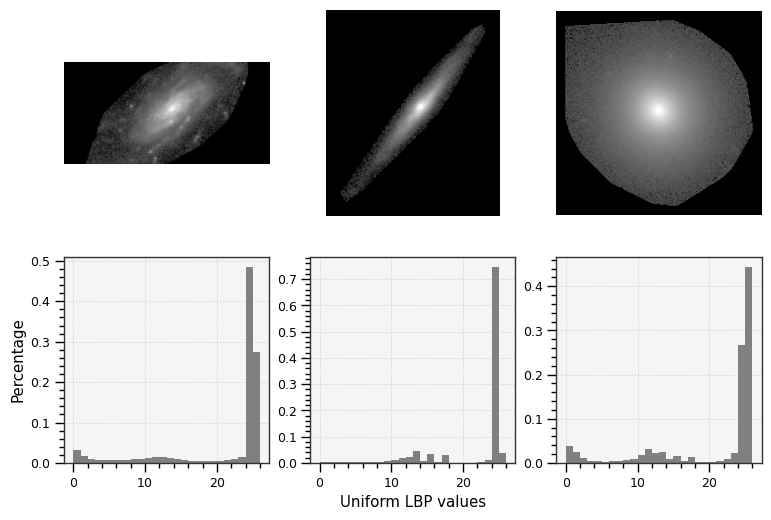

In [157]:
def kullback_leibler_divergence(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))


def match(refs, img):
    best_score = 10
    best_name = None
    lbp = local_binary_pattern(img, n_points, radius, METHOD)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    for name, ref in refs.items():
        ref_hist, _ = np.histogram(ref, density=True, bins=n_bins,
                                   range=(0, n_bins))
        score = kullback_leibler_divergence(hist, ref_hist)
        if score < best_score:
            best_score = score
            best_name = name
    return best_name


spiral = gray
edgeon = mapped
refs = {
    'spiral': local_binary_pattern(spiral, n_points, radius, METHOD),
    'edgeon': local_binary_pattern(edgeon, n_points, radius, METHOD),
    'etg': local_binary_pattern(etg, n_points, radius, METHOD)
}

# classify rotated textures
print('Rotated images matched against references using LBP:')
print('original: spiral, rotated: 30deg, match result: ',
      match(refs, rotate(spiral, angle=30, resize=False)))
print('original: edgeon, rotated: 70deg, match result: ',
      match(refs, rotate(edgeon, angle=70, resize=False)))
print('original: etg, rotated: 145deg, match result: ',
      match(refs, rotate(etg, angle=145, resize=False)))

# plot histograms of LBP of textures
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3,
                                                       figsize=(9, 6))
plt.gray()

ax1.imshow(rotate(spiral, angle=30, resize=False))
ax1.axis('off')
hist(ax4, local_binary_pattern(rotate(spiral, angle=30, resize=False), n_points, radius, METHOD))
ax4.set_ylabel('Percentage')

ax2.imshow(edgeon)
ax2.axis('off')
hist(ax5, refs['edgeon'])
ax5.set_xlabel('Uniform LBP values')

ax3.imshow(etg)
ax3.axis('off')
hist(ax6, refs['etg'])

plt.show()

## GLCM Texture Features
(DOI:10.1109/TSMC.1973.4309314)